## 프로젝트 목표
---
1. 한글 코퍼스를 가공하여 BERT pretrain용 데이터셋을 잘 생성하였다.
   * MLM, NSP task의 특징이 잘 반영된 pretrain용 데이터셋 생성과정이 체계적으로 진행되었다.
2. 구현한 BERT 모델의 학습이 안정적으로 진행됨을 확인하였다.
   * 학습진행 과정 중에 MLM, NSP loss의 안정적인 감소가 확인되었다.
3. 1M짜리 mini BERT 모델의 제작과 학습이 정상적으로 진행되었다.
   * 학습된 모델 및 학습과정의 시각화 내역이 제출되었다.

### 라이브러리 import

In [184]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import wandb
from wandb.integration.keras import WandbMetricsLogger

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.16.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


2025-03-17 09:28:04.528860: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-17 09:28:04.528936: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 1. Tokenizer 준비
---
SentencePiece 모델을 이용해 BERT의 MLM 학습용 데이터를 만드세요.

이를 위해 한글 나무 위키 코퍼스로부터 8000의 vocab_size를 갖는 sentencepiece 모델을 만들어 보세요. BERT에 사용되는 주요 특수문자가 vocab에 포함되어야 합니다. (시간이 부족하다면 클라우드에 저장된 sentencepiece 모델을 사용하세요.)

<div style="background-color: #000; color: #fff; padding: 10px;">
    
    $ python
    >>> import sentencepiece as spm
    >>> import os
    >>> corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'
    >>> prefix = os.getenv('HOME')+'/aiffel/bert_pretrain/models/k010k_ko_8000'
    >>> vocab_size = 8000
    >>> spm.SentencePieceTrainer.train(f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7} --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]")
    
</div>

![spm_token_8000](./spm_token_8000.png)

In [185]:
data_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/models'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/k010k_ko_8000.model")

True

In [186]:
#Q. 특수 token 7개를 제외한 나머지 token들을 출력해봅시다.
vocab_list = []
for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))
print("특수 token 7개를 제외한 나머지 token:", vocab_list[:100])   

특수 token 7개를 제외한 나머지 token: ['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다', '었다', '▁지', '▁수', '▁19', '▁가', '▁시', '▁20', '▁기', '▁전', '▁아', '▁하', '▁있다', '▁다', '▁제', '했다', '하였', '▁일', '▁한', '▁중', '▁정', '▁주', '하는', '▁것', '▁자', '▁공', '▁인', '되었다', '▁경', '▁위', '▁유', '▁보', '하고', '▁3', '▁등', '▁부', '하였다', '▁조', '하여', '▁미', '▁동', '▁선', '▁나', '으며', '▁모', '▁연', '▁영', '▁의', '▁오', '▁마', '에는', '▁발', '▁소', '한다', '▁고', '▁개', '▁201', '▁구', '▁세', '▁도', '▁상', '▁비', '▁스', '▁국', '▁서', '▁후', '▁여', '▁200', '▁때', '▁4', '▁성', '▁해', '▁관', '▁있는', '▁신', '▁프', '▁대한', '부터', '▁5', '00', '▁방', '▁또', '지만', '▁(', '▁역', '되어', '▁않', '▁만', '▁"', '▁장', '▁바']


In [187]:
# [CLS], tokens a, [SEP], tokens b, [SEP] 형태의 token 생성
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]
print(tokens_org)

['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


### 2. 데이터 전처리 (1) MASK 생성
---
BERT의 MLM(Masked Language Model)에 필요한 빈칸(mask)을 학습 데이터 전체 토큰의 15% 정도로 만들어 주세요. 그 중 80%는 [MASK] 토큰, 10%는 랜덤한 토큰, 나머지 10%는 원래의 토큰을 그대로 사용하세요.

**🔶 create_pretrain_mask() : Masked LM을 위한 코퍼스 생성 메소드**

---
* 전체 토큰의 15%를 대상으로 [MASK] 토큰: 80%, 랜덤 토큰: 10%, 원래 토큰 그대로: 10%
* 마스킹 된 다음 빈칸에 알맞은 단어는? 문제를 푸는 형식
* Subword 기반으로 토크나이징을 했을 때 _대, [MASK], 민국이라고 가운데를 마스킹 했을 경우 해당 [MASK]가 '한'일 거라는 건 너무 쉽게 맞출 수 있습니다. '대한민국'이라는 패턴을 아주 자주 보기 때문
*  Masked LM 태스크를 구성할 땐 ***띄어쓰기 단위로 한꺼번에 마스킹***
*  random mask를 위해서 index 순서를 섞음

In [188]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    # random mask를 위해서 순서를 섞음 (shuffle)
    random.shuffle(cand_idx)
    ###################################################
    # mask_lms 정렬 후 mask_idx, mask_label 추출 (sorted 사용)
    # Step : mask_lms 생성 및 마스크 로직 적용
    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
              break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
              continue
        dice = random.random()  # 0과 1 사이의 확률 값
    
        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
            
    # Step : mask_lms 정렬 후 mask_idx, mask_label 추출
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])  # 인덱스 순으로 정렬
    mask_idx = [item["index"] for item in mask_lms]  # 마스크된 인덱스
    mask_label = [item["label"] for item in mask_lms]  
    
    return tokens, mask_idx, mask_label

### 3. 데이터 전처리 (2) NSP pair 생성
---
BERT의 pretrain task인 NSP는 두 문장이 연속하는지 확인하는 것입니다. 이를 위해 2개의 문장을 짝지어 50%의 확률로 TRUE와 FALSE를 지정해 주세요.

두 문장 사이에 segment 처리를 해주세요. 첫 번째 문장의 segment는 0, 두 번째 문장은 1로 채워준 후 둘 사이에 구분자인 [SEP] 등을 넣어주세요.

MLM과 NSP는 동시에 학습된다는 것을 염두에 두고 학습 데이터를 구성해 보세요.

**🔶 create_pretrain_instances() : Next Sentence Prediction을 위한 코퍼스 생성 메소드**

---
 * 문장 2개를 붙여 놓고 두 문장이 이어지는 것인지 아닌지 문장 호응관계를 맞출 수 있게 하는 것
 * 넣어줄 특수 token은 [CLS]와 [SEP]이고, sequence의 최대 길이는 n_test_seq - 3
 * 짝지은 두 문장을 그대로 두면 NSP task의 true label 케이스가 되고, 둘의 순서를 뒤바꾸면 false label 케이스
 * 두 문장의 최대 길이를 유지하도록 trim을 적용한 후 50%의 확률로 true/false 케이스를 생성
 * token A의 길이가 max_seq보다 길면 앞에서부터 토큰을 제거하고, token B의 길이가 길면 뒤에서부터 토큰을 제거

In [189]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])  # line 단위로 추가
        current_length += len(doc[i])  # current_chunk의 token 수
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
            print("current_chunk:", len(current_chunk), current_length, current_chunk)
    
            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])
    
            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0    # False
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1   # True
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
    
            print("is_next:", is_next)
            print("tokens_a:", len(tokens_a), tokens_a)
            print("tokens_b:", len(tokens_b), tokens_b)
            #######################################
    
            # tokens & segment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            print("tokens:", len(tokens), tokens)
            print("segment:", len(segment), segment)
            
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * 0.15), vocab_list)
            print("masked tokens:", len(tokens), tokens)
            print("masked index:", len(mask_idx), mask_idx)
            print("masked label:", len(mask_label), mask_label)
    
            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)
            #######################################
            print()
    
            current_chunk = []
            current_length = 0
    return instances

### 4. 데이터 전처리 (3) 데이터셋 완성
---
BERT pretrain 데이터셋을 생성해, json 포맷으로 저장하세요. 데이터셋의 사이즈가 크므로np.memmap을 사용해 메모리 사용량을 최소화해 보세요.

**🔶 make_pretrain_data() : BERT pretrain 데이터셋 생성 메소드**


In [190]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [191]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다. 
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = [] # 현재 문서 내용 저장
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip() # 공백 제거
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if 0 < len(doc):
                        # save
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)    
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                # save
                save_pretrain_instances(out_f, doc)
                doc = []

### 4. 데이터 전처리 (3) 데이터셋 완성
---
BERT pretrain 데이터셋을 생성해, json 포맷으로 저장하세요. 데이터셋의 사이즈가 크므로np.memmap을 사용해 메모리 사용량을 최소화해 보세요.

In [192]:
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'
pretrain_json_path = os.getenv('HOME')+'/aiffel/bert_pretrain/data/8000_pre_train.json'

In [193]:
make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub data rate exceeded.
The Jupyter

current_chunk: 2 14 [['▁후', '지', '마', '키'], ['▁후', '지', '마', '키', '의', '▁다른', '▁뜻은', '▁다음과', '▁같다', '.']]
is_next: 1
tokens_a: 4 ['▁후', '지', '마', '키']
tokens_b: 10 ['▁후', '지', '마', '키', '의', '▁다른', '▁뜻은', '▁다음과', '▁같다', '.']
tokens: 17 ['[CLS]', '▁후', '지', '마', '키', '[SEP]', '▁후', '지', '마', '키', '의', '▁다른', '▁뜻은', '▁다음과', '▁같다', '.', '[SEP]']
segment: 17 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
masked tokens: 17 ['[CLS]', '▁후', '지', '마', '키', '[SEP]', '▁후', '지', '마', '키', '의', '[MASK]', '[MASK]', '▁다음과', '▁같다', '.', '[SEP]']
masked index: 2 [11, 12]
masked label: 2 ['▁다른', '▁뜻은']

current_chunk: 2 13 [['▁고', '드', '프', '리'], ['▁고', '드', '프', '리의', '▁다른', '▁뜻은', '▁다음과', '▁같다', '.']]
is_next: 0
tokens_a: 9 ['▁고', '드', '프', '리의', '▁다른', '▁뜻은', '▁다음과', '▁같다', '.']
tokens_b: 4 ['▁고', '드', '프', '리']
tokens: 16 ['[CLS]', '▁고', '드', '프', '리의', '▁다른', '▁뜻은', '▁다음과', '▁같다', '.', '[SEP]', '▁고', '드', '프', '리', '[SEP]']
segment: 16 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
masked t

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub data rate exceeded.
The Jupyter

In [194]:
# 라인수
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

918173

**🔶 load_pre_train_data() : 학습에 필요한 데이터를 로딩하는 함수**

---
* np.memmap을 사용해서 메모리 사용량을 최소화
* np.memmap을 사용해 메모리 효율적으로 만들어진 데이터를 로딩하는 함수 구성

In [195]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int32)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int32)
            label_mlm = np.full(n_seq, dtype=np.int32, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [196]:
# 300000건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=300000)

  0%|          | 0/300000 [00:00<?, ?it/s]

data load early stop 300000 300000


In [197]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   5,   10, 1607, 3599, 1756, 3630,   41, 3644,  830, 3624, 1135,
           52, 3599,   13,   81,   87, 1502, 2247,   25, 3779, 3873, 3667,
         3631, 3813, 3873, 4196, 3636, 3779, 3601,  249, 3725, 1233,   33,
           52, 3599,    6,    6,    6, 6322, 2780,   14, 1510,  168, 3877,
          414,  166, 1697, 4290, 3873, 3703, 3683,  593,   21, 5007,  399,
         1928, 3607,    6,    6,    6,    6,    6,    6,  104, 4313, 4290,
          613, 3638, 3718,   99, 3878, 3656,  256, 2543,  309,  337, 3735,
          181, 3616, 3603,  489,  376, 3599,    4,    6,    6,  207, 3714,
            6, 1042,  104, 3610, 3686, 3718,    6,    6,   37, 3417,  416,
          810, 3666, 3625,  160, 3662,    7, 3629,  203,  241, 3602, 1114,
         3724,  788,  243,    6,    6,    6,  663, 1648, 3682, 3682, 3625,
          203, 3009, 3625, 3616,   16, 3599,    4], dtype=int32),
 memmap([   5,  254, 3736, 3614, 3626,    4,  123, 3821, 3736, 3614, 3626,
         3837, 3602,  447, 2789,  

### 5. BERT 모델 구현
---
pad mask, ahead mask 함수, gelu activation 함수, parameter initializer 생성 함수, json을 config 형태로 사용하기 위한 유틸리티 함수를 먼저 만들어 두세요.

Embedding 레이어, Transformer encoder 레이어, BERT 레이어를 구성한 후, pretraine용 BERT 모델을 만들어 봅시다.

**유틸리티 함수들**

---

In [198]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer

**BERT 모델 생성을 위한 클래스들**

---

In [199]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

***Embedding Layer***

 * Token Embedding

In [200]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                name="weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

***Position Embedding***

---
* 위치 정보가 담긴 임베딩 레이어를 하나 더 사용해 Position Embedding 벡터를 학습
* BERT의 입력에 Position Embedding을 더 함.

In [201]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

**Segment Embedding은 별도의 레이어를 구현하지 않고 BERT 클래스에서 간단히 포함**

***ScaleDotProductAttention과 이를 활용한 MultiHeadAttention***

In [202]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [203]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m) # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)        
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, self.n_head * self.d_head]) # (bs, Q_len, d_model)               
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

**Encoder Layer**

---

In [204]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [205]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

**BERT**

---

In [206]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        # self.config = config
        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        # Mask for padding tokens
        # enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)
        enc_self_mask = tf.keras.layers.Lambda(lambda x: get_pad_mask(x, self.i_pad),output_shape=(1, None),name='enc_self_mask')(enc_tokens)

        # Embedding
        enc_embed = self.get_embedding(enc_tokens, segments)

        # Encoder layers
        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        # Outputs
        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        
        return embed


    # def get_config(self):
    #     """
    #     Return the configuration of the BERT layer for serialization
    #     """
    #     config = super().get_config()  # Get base config
    #     config.update({
    #         "config": self.config,  # Save the entire Config object
    #     })
    #     return config

    # @classmethod
    # def from_config(cls, config):
    #     """
    #     Reconstruct the BERT object from its config
    #     """
    #     config_obj = config["config"]  # Retrieve the saved Config object
    #     return cls(config=config_obj)

In [207]:
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

In [208]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(
        inputs=(enc_tokens, segments), 
        outputs=(outputs_nsp, outputs_mlm),
        name=config.model_name
    )
    return model

### 6. pretrain 진행
---
loss, accuracy 함수를 정의하고 Learning Rate 스케쥴링을 구현한 후, 10 Epoch까지 모델 학습을 시켜보세요. 학습을 진행할 때는 배치 사이즈에 유의하세요.

***아주 작은 pretrain용 BERT 모델(test_model)을 생성하여 동작을 확인***

---

In [209]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0, "model_name": "k010k"})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007,
 'i_pad': 0,
 'model_name': 'k010k'}

In [210]:
n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["acc", "acc"])

# test model fit
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 9.7247 - mlm_acc: 0.0000e+00 - mlm_loss: 9.0096 - nsp_acc: 0.2000 - nsp_loss: 0.7151
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 8.4088 - mlm_acc: 0.0067 - mlm_loss: 7.8078 - nsp_acc: 1.0000 - nsp_loss: 0.6010    


**pretrain 진행**

---
 * 학습 데이터의 label이 정수로 변환되었으므로 loss 함수는 SparseCategoricalCrossentropy를 사용
 * MLM task에 대해 더 잘 학습하도록 loss를 20배 증가

In [211]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    # loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    loss = {"nsp": nsp_loss, "mlm": lambda y_true, y_pred: 20 * mlm_loss(y_true, y_pred)}
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

<div style="background-color: #000; color: #fff; padding: 10px;">
    
    * learning Rate 스케줄링은 WarmUp 이후 consine 형태로 감소하는 스케줄을 적용
    * Learning Rate를 단순히 감소시키기 보다는 진동하면서 최적점을 찾아가는 방식을 많이 사용
    * 다양한 방법을 찾아서 적용시켜 보는 것도 성능을 높이는 좋은 방법
</div>

In [212]:
import tensorflow as tf
import math
from typing import Optional

class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule with Warmup and Optional Logging
    """

    def __init__(self, train_steps: int = 4000, warmup_steps: int = 2000, max_lr: float = 2.5e-4):
        super().__init__()
        assert 0 < warmup_steps < train_steps, "warmup_steps must be less than train_steps."
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num, log=False):
        is_warmup = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(tf.constant(math.pi, dtype=tf.float32) * progress))
        learning_rate = (is_warmup * lr1 + (1 - is_warmup) * lr2) * self.max_lr

        if log:
            tf.print(f"Step {step_num}: Learning Rate = {learning_rate}")
        return learning_rate

    def update_steps(self, train_steps: Optional[int] = None, warmup_steps: Optional[int] = None):
        if train_steps:
            self.train_steps = train_steps
        if warmup_steps:
            self.warmup_steps = warmup_steps


class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps     
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr


test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500, max_lr=1.5e-4)
for step in range(100):  # Test for 100 steps
    test_schedule(step, log=True)
    
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

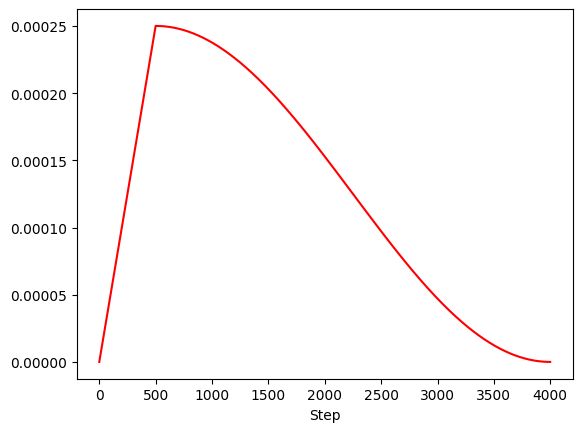

In [213]:
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

***모델 생성***

---

In [214]:
pre_train_model = build_model_pre_train(config)
print(pre_train_model.name) 
pre_train_model.summary()

k010k


Model: "k010k"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_tokens          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segments            │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert (BERT)         │ [(None, 256),     │  4,485,632 │ enc_tokens[0][0], │
│                     │ (None, None,      │            │ segments[0][0]    │
│                     │ 8007)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_nsp          │ (None, 2)         │     66,304 │ bert[0][0]        │
│ (PooledOutput)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nsp (Softmax)       │ (None, 2)         │          0 │ pooled_nsp[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlm (Softmax)       │ (None, None,      │          0 │ bert[0][1]        │
│                     │ 8007)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,551,936 (17.36 MB)

 Trainable params: 4,551,936 (17.36 MB)

 Non-trainable params: 0 (0.00 B)

In [215]:
epochs = 20
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
# Defalult
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
# First Try
# learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10), max_lr=1.5e-4)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
# pre_train_model.compile(
#     loss={
#         "nsp": tf.keras.losses.SparseCategoricalCrossentropy(),
#         "mlm": lambda y_true, y_pred: 20 * lm_loss(y_true, y_pred)  # Multiply MLM loss by 20
#     },
#     optimizer=optimizer,
#     metrics={
#         "nsp": "acc",  # Accuracy metric for NSP
#         "mlm": "acc"   # Accuracy metric for MLM
#     }
# )

pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": "acc"})

train_steps: 93760


In [216]:
save_weights = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{model_dir}/8000_pre_train.weights.h5", 
    monitor="mlm_acc", verbose=1, save_best_only=True, 
    mode="max", save_freq="epoch", save_weights_only=True
)
# train
history = test_model.fit(
    x=(enc_tokens, segments),  # 입력 데이터
    y=(labels_nsp, labels_mlm),  # 레이블 데이터
    epochs=10,  # 에포크 수
    batch_size=64,  # 배치 크기
    callbacks=[save_weights]  # 콜백 리스트
)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 7.7681 - mlm_acc: 0.1700 - mlm_loss: 7.2111 - nsp_acc: 1.0000 - nsp_loss: 0.5571
Epoch 1: mlm_acc improved from -inf to 0.17000, saving model to /Users/k.010k/aiffel/bert_pretrain/models/8000_pre_train.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 7.7681 - mlm_acc: 0.1700 - mlm_loss: 7.2111 - nsp_acc: 1.0000 - nsp_loss: 0.5571
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 7.2913 - mlm_acc: 0.3600 - mlm_loss: 6.7981 - nsp_acc: 1.0000 - nsp_loss: 0.4933
Epoch 2: mlm_acc improved from 0.17000 to 0.36000, saving model to /Users/k.010k/aiffel/bert_pretrain/models/8000_pre_train.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step - loss: 7.2913 - mlm_acc: 0.3600 - mlm_loss: 6.7981 - nsp_acc: 1.0000 - nsp_loss: 0.4933
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 6.8096 - mlm_acc: 0.5100 - mlm_loss: 6.3857 - nsp_acc: 1.0000 - nsp_loss: 0.4238
Epoch 3: mlm_acc improved from 0.36000 to 0.51000, saving model to 

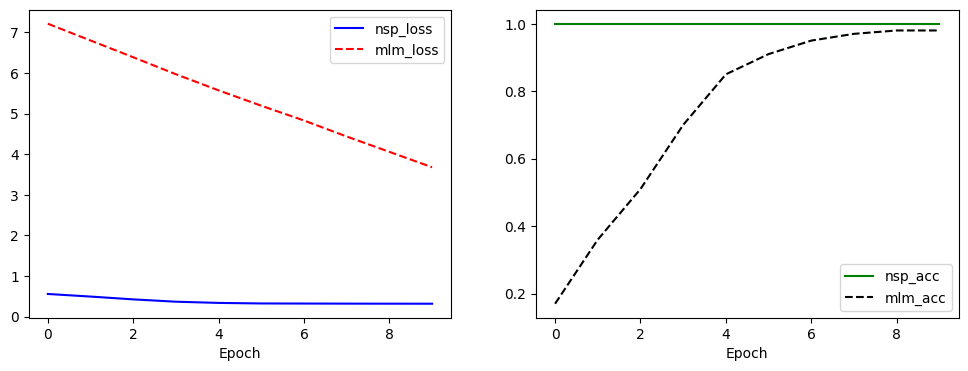

In [217]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

### 테스트 진행 리스트

1. mlm loss 줄이는 방법
2. unigram 으로 토큰화 한 후 비교 

### 테스트 결과

0. 최초 실행 결과
 ![bert_epoch_20_result](./bert_epoch_20_result.png)
2. CosineSchedule의  max_lr를 2.5e-4 --> 1.5e-4
   * loss 차이가 거의 없음.
3. epoch 10 --> 20
   큰 차이 발생 하지 않음(3.7791 --> 3.6791)
    ![bert_first_result](bert_first_result.png)
5. MLM 손실의 비중을 크게 설정하여 모델이 MLM task에 더 중점   
   loss = {"nsp": nsp_loss, "mlm": lambda y_true, y_pred: 20 * mlm_loss(y_true, y_pred)}
    mlm_loss: 3.6600
6. 드롭아웃 비율(config.dropout)을 낮추어 모델이 더 많은 정보를 학습하도록 유도
   * 0.1이라 더 낮출 수 없음 

### 회고

---
* mlm loss를 줄이기 위하여 다양한 방법을 시도 하였으나 크게 줄이지는 못함.
* 옵티마이저 최적화를 위해 wandb 적용을 위한 시도를 하였으나 wandb에서 제공하는 keras, tensorflow 예시가 적용 되지 않아 실패함.
* unigram 토근화 후 진행은 시간이 부족하여 더 테스트 하지 못함

**pretrain model을 위한 전체 적인 프로세스는 이해 되었으나, mlm loss 줄이는 방법은 효과적으로 찾지 못해 아쉬움이 많이 나음.특히 wandb 적용을 못한 부분이 아쉬움이 더함.**